## Assignment: Predicting House Prices

Now, it's your turn to design your first regression model.  You'll be using a version of the "House Prices" dataset from Kaggle from a Postgres database.  This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa.  Using this data, you task will be to predict the prices of the houses.  You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

* Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:

```python
        postgres_user = 'dsbc_student'
        postgres_pw = '7*.8G9QH21'
        postgres_host = '142.93.121.174'
        postgres_port = '5432'
        postgres_db = 'houseprices'
```

* Please follow the example above and call `engine.dispose()` when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.
* Investigate the data, and do any necessary data cleaning.
* Explore the data and find some variables that you think would be useful in predicting house prices.
* Build your initial model using these features and estimate the parameters using OLS.


Spend up to 4 hours on this assignment. When you are done and have submitted a link to your notebook below, feel free to take a look at [this example solution](https://github.com/Thinkful-Ed/machine-learning-regression-problems/blob/master/notebooks/2.solution_simple_linear_regression_models.ipynb).

## Data fields
Here's a brief version of what you'll find in the data description file.

- SalePrice - the property's sale price in dollars. This is the target variable that you're trying to - predict.
- MSSubClass: The building class
- MSZoning: The general zoning classification
- LotFrontage: Linear feet of street connected to property
- LotArea: Lot size in square feet
- Street: Type of road access
- Alley: Type of alley access
- LotShape: General shape of property
- LandContour: Flatness of the property
- Utilities: Type of utilities available
- LotConfig: Lot configuration
- LandSlope: Slope of property
- Neighborhood: Physical locations within Ames city limits
- Condition1: Proximity to main road or railroad
- Condition2: Proximity to main road or railroad (if a second is present)
- BldgType: Type of dwelling
- HouseStyle: Style of dwelling
- OverallQual: Overall material and finish quality
- OverallCond: Overall condition rating
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date
- RoofStyle: Type of roof
- RoofMatl: Roof material
- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)
- MasVnrType: Masonry veneer type
- MasVnrArea: Masonry veneer area in square feet
- ExterQual: Exterior material quality
- ExterCond: Present condition of the material on the exterior
- Foundation: Type of foundation
- BsmtQual: Height of the basement
- BsmtCond: General condition of the basement
- BsmtExposure: Walkout or garden level basement walls
- BsmtFinType1: Quality of basement finished area
- BsmtFinSF1: Type 1 finished square feet
- BsmtFinType2: Quality of second finished area (if present)
- BsmtFinSF2: Type 2 finished square feet
- BsmtUnfSF: Unfinished square feet of basement area
- TotalBsmtSF: Total square feet of basement area
- Heating: Type of heating
- HeatingQC: Heating quality and condition
- CentralAir: Central air conditioning
- Electrical: Electrical system
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet
- LowQualFinSF: Low quality finished square feet (all floors)
- GrLivArea: Above grade (ground) living area square feet
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms
- FullBath: Full bathrooms above grade
- HalfBath: Half baths above grade
- Bedroom: Number of bedrooms above basement level
- Kitchen: Number of kitchens
- KitchenQual: Kitchen quality
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- Functional: Home functionality rating
- Fireplaces: Number of fireplaces
- FireplaceQu: Fireplace quality
- GarageType: Garage location
- GarageYrBlt: Year garage was built
- GarageFinish: Interior finish of the garage
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- GarageQual: Garage quality
- GarageCond: Garage condition
- PavedDrive: Paved driveway
- WoodDeckSF: Wood deck area in square feet
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet
- PoolArea: Pool area in square feet
- PoolQC: Pool quality
- Fence: Fence quality
- MiscFeature: Miscellaneous feature not covered in other categories
- MiscVal: $Value of miscellaneous feature
- MoSold: Month Sold
- YrSold: Year Sold
- SaleType: Type of sale
- SaleCondition: Condition of sale

In [42]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec # Null visualization
import seaborn as sns
import statsmodels.api as sm 

import warnings
import missingno 
import math

from sklearn import linear_model 
from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL 
from scipy.stats import zscore
from scipy.stats.mstats import winsorize

warnings.filterwarnings('ignore')

kagle = dict(
    drivername = 'postgresql',
    username = 'dsbc_student',
    password = '7*.8G9QH21',
    host = '142.93.121.174',
    port = '5432',
    database = 'houseprices',
)

In [2]:
def null_rpt_cat_cols(df):
    """ This function takes in a dataframe, picks out the categorical columns ('object','category','datetime64[ns]') and reports back the number of nulls, the null percentage and number of unique values. The function also returns a list of the categorical column names."""

    categorical_df = df.select_dtypes(include=["category","object","datetime64[ns]"])

    total_missing = categorical_df.isnull().sum().sort_values(ascending=False)
    percent_missing = (categorical_df.isnull().sum()/categorical_df.isnull().count()).sort_values(ascending=False)
    uniques = categorical_df.nunique().sort_values(ascending=False)

    missing_info = dict(
        total_missing=total_missing, 
        percent_missing=percent_missing, 
        uniques=uniques
    )

    missing_data = pd.DataFrame(missing_info)
    missing_data = missing_data.reset_index()
    missing_data = missing_data.rename(columns=dict(index="cols"))

    return missing_data

In [3]:
def null_rpt_contin_cols(df):
    """ This function takes in a dataframe, excludes the continuous columns ('object','category') and reports back the number of nulls, the null percentage and number of unique values. The function also returns a list of the categorical column names.  Notice that datetime is included, in case you want to treat it as a continuous variable."""

    continuous_df = df.select_dtypes(exclude=["object","category"])

    total_missing = continuous_df.isnull().sum().sort_values(ascending=False)
    percent_missing = (continuous_df.isnull().sum()/continuous_df.isnull().count()).sort_values(ascending=False)
    uniques = continuous_df.nunique().sort_values(ascending=False)

    missing_info = dict(
        total_missing=total_missing, 
        percent_missing=percent_missing, 
        uniques=uniques
    )

    missing_data = pd.DataFrame(missing_info)
    missing_data = missing_data.reset_index()
    missing_data = missing_data.rename(columns=dict(index="cols"))

    return missing_data

In [4]:
# Generate a visual representation of nulls in the dataset
def report_null_entries(df):
    if len(df[df.isnull().any(axis=1)] != 0):
        print(f"Number of null values: {len(df[df.isnull().any(axis=1)])}")
        missingno.matrix(df)
        plt.show()
    else:
        print("No rows with null values found.")

In [5]:
# Retun a pandas dataframe to help establish z-score thresholds for outlier detection.
def threshold_rpt(df): 
    """ Function takes in a dataframe and returns a new dataframe with outlier counts by z-score."""
    
    # Parent list to build dataframe from 
    z_score_lists = list()
    
    # Select the continuous columns from the dataframe
    continuous_cols = df.select_dtypes(exclude=["object","category","datetime64[ns]"]).columns

    # Loop over the columns, after the index and calculate z-scores
    for col in continuous_cols[1:]:
        z_scores = zscore(df[col])

        # Establish thresholds and determine the outliers at each threshold
        for threshold in range(1,7):
            z_score_threshold = [col,threshold,len(np.where(z_scores > threshold)[0])]

            z_score_lists.append(z_score_threshold)

    # Build the return dataframe from the parent list from above
    thresholds_df = pd.DataFrame(z_score_lists)
    thresholds_df = thresholds_df.rename(columns={0:"col",1:"threshold",2:"outliers"})
    
    return thresholds_df

In [20]:
# Plot a correlaiton matrix
def corr_plot(corr_mat,figsize):
    """
        Pass in a correlation matrix and figsize (as a tuple) and plot the corresponding heatmap.
    """
    plt.figure(figsize=figsize)

    sns.heatmap(corr_mat, square=True, annot=True, linewidth=0.5)
    plt.title(f"Correlation matrix of winsorized variables")

    # Fix display issues for this version of matplotlib
    b,t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b,t)
    # plt.yticks(rotation=360)

    plt.show();

In [6]:
# Load the data from the "houseprices" database
engine=create_engine(URL(**kagle), echo=True)

houses_raw=pd.read_sql_query("SELECT * FROM houseprices", con=engine)

engine.dispose()

2019-12-26 19:32:53,076 INFO sqlalchemy.engine.base.Engine select version()
2019-12-26 19:32:53,076 INFO sqlalchemy.engine.base.Engine {}
2019-12-26 19:32:53,176 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-12-26 19:32:53,177 INFO sqlalchemy.engine.base.Engine {}
2019-12-26 19:32:53,281 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-12-26 19:32:53,282 INFO sqlalchemy.engine.base.Engine {}
2019-12-26 19:32:53,338 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-12-26 19:32:53,339 INFO sqlalchemy.engine.base.Engine {}
2019-12-26 19:32:53,390 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-12-26 19:32:53,391 INFO sqlalchemy.engine.base.Engine {}
2019-12-26 19:32:53,492 INFO sqlalchemy.engine.base.Engine SELECT * FROM houseprices
2019-12-26 19:32:53,493 INFO sqlalchemy.engine.base.Engine {}


In [7]:
# Take a look at a random sample of the houseprices data
houses_raw.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [8]:
houses_raw.iloc[:,:10].sample(n=10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities
886,887,90,RL,70.0,8393,Pave,None,Reg,Lvl,AllPub
798,799,60,RL,104.0,13518,Pave,None,Reg,Lvl,AllPub
590,591,60,RL,64.0,8320,Pave,None,Reg,Lvl,AllPub
554,555,60,RL,85.0,10625,Pave,None,Reg,Lvl,AllPub
441,441,20,RL,105.0,15431,Pave,None,Reg,Lvl,AllPub
437,437,50,RM,40.0,4400,Pave,None,Reg,Lvl,AllPub
1030,1031,190,RH,NaN,7082,Pave,None,Reg,Lvl,AllPub
186,186,75,RM,90.0,22950,Pave,None,IR2,Lvl,AllPub
1241,1241,60,RL,65.0,8158,Pave,None,Reg,Lvl,AllPub
391,391,50,RL,50.0,8405,Pave,Grvl,Reg,Lvl,AllPub


In [9]:
# To make for clearer printing get the length of the longest column name and that column name
max_length, longest_col_name = max([len(x),x] for x in list(houses_raw.columns))

# Print out the number of unique values for each variable to help identify categorical varaibles
for col in houses_raw.columns:
    print(f"{col:<{max_length}}: {len(houses_raw[col].unique()):>{4}}")

id           : 1460
mssubclass   :   15
mszoning     :    5
lotfrontage  :  111
lotarea      : 1073
street       :    2
alley        :    3
lotshape     :    4
landcontour  :    4
utilities    :    2
lotconfig    :    5
landslope    :    3
neighborhood :   25
condition1   :    9
condition2   :    8
bldgtype     :    5
housestyle   :    8
overallqual  :   10
overallcond  :    9
yearbuilt    :  112
yearremodadd :   61
roofstyle    :    6
roofmatl     :    8
exterior1st  :   15
exterior2nd  :   16
masvnrtype   :    5
masvnrarea   :  328
exterqual    :    4
extercond    :    5
foundation   :    6
bsmtqual     :    5
bsmtcond     :    5
bsmtexposure :    5
bsmtfintype1 :    7
bsmtfinsf1   :  637
bsmtfintype2 :    7
bsmtfinsf2   :  144
bsmtunfsf    :  780
totalbsmtsf  :  721
heating      :    6
heatingqc    :    5
centralair   :    2
electrical   :    6
firstflrsf   :  753
secondflrsf  :  417
lowqualfinsf :   24
grlivarea    :  861
bsmtfullbath :    4
bsmthalfbath :    3
fullbath     :    4


In [10]:
# Run the null report function for categorical columns
cat_cols = null_rpt_cat_cols(houses_raw)

# Display only the columns with null values
cat_cols[cat_cols["total_missing"]>0].sort_values(by="total_missing",ascending=False)

,cols,total_missing,percent_missing,uniques
36,poolqc,1453,0.995205,3
32,miscfeature,1406,0.963014,4
0,alley,1369,0.937671,2
15,fence,1179,0.807534,4
16,fireplacequ,690,0.472603,5
19,garagecond,81,0.055479,5
20,garagefinish,81,0.055479,3
21,garagequal,81,0.055479,5
22,garagetype,81,0.055479,6
3,bsmtexposure,38,0.026027,4


Number of null values: 1460


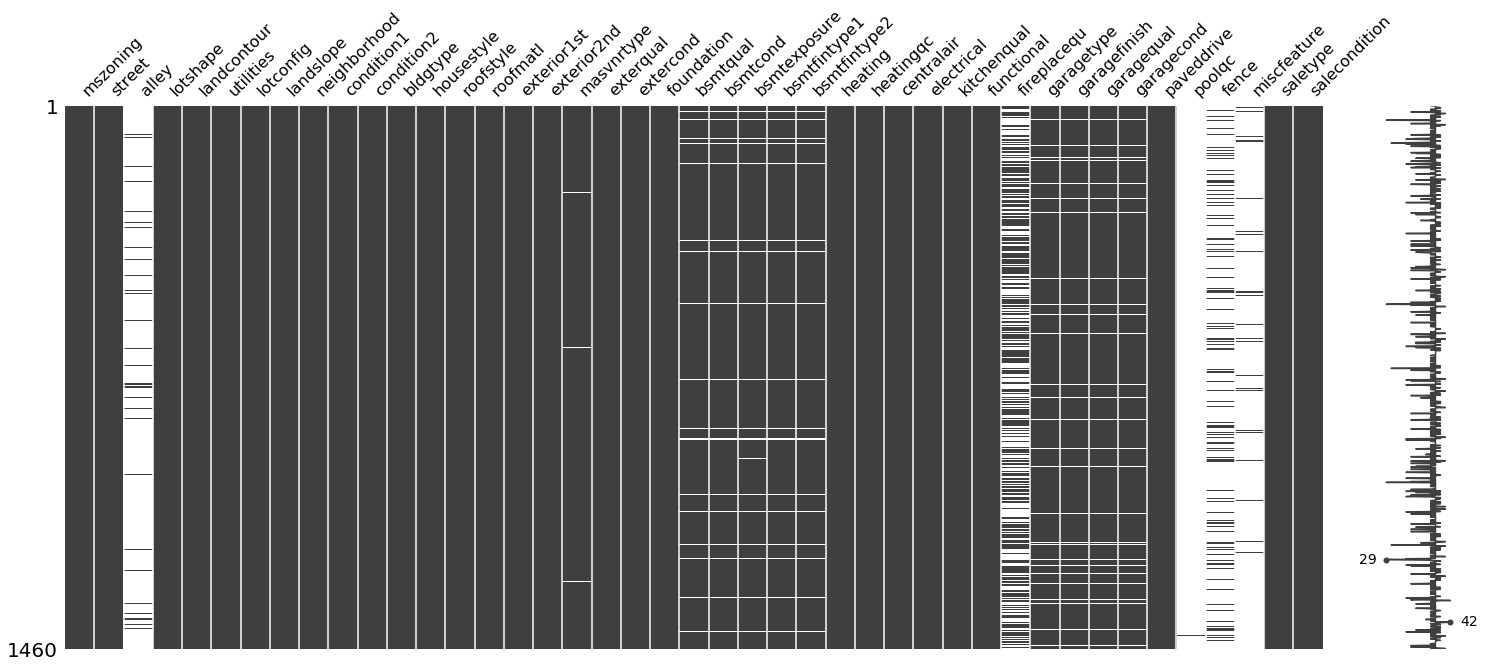

In [11]:
# Strip out the categorical columns and visualize the nulls
categorical_df = houses_raw.select_dtypes(include=["category","object","datetime64[ns]"])

# Visualize the nulls
report_null_entries(categorical_df)

In [12]:
# Run the null report function for condinuous columns
contin_cols = null_rpt_contin_cols(houses_raw)

# Display only the columns with null values
contin_cols[contin_cols["total_missing"]>0].sort_values(by="total_missing",ascending=False)

,cols,total_missing,percent_missing,uniques
18,lotfrontage,259,0.177397,110
12,garageyrblt,81,0.055479,97
20,masvnrarea,8,0.005479,327


Number of null values: 339


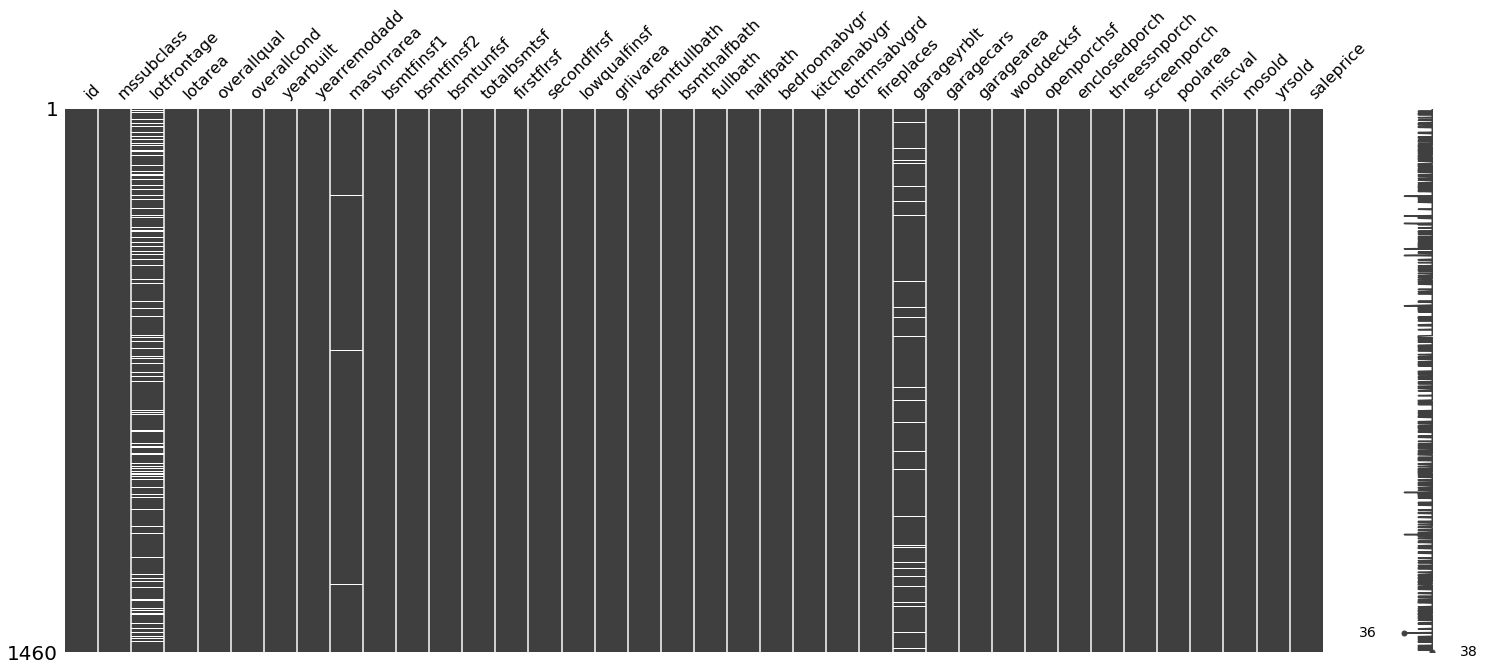

In [13]:
# Strip out the categorical columns and visualize the nulls
continuous_df = houses_raw.select_dtypes(exclude=["category","object"])

# Visualize the nulls
report_null_entries(continuous_df)

In [14]:
# Interpolate missing values 
houses_raw.groupby(["neighborhood","yearbuilt",
    'firstflrsf']).apply(lambda group: group.interpolate(limit_direction="both"))

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2010,WD,Normal,142125


Number of null values: 1460


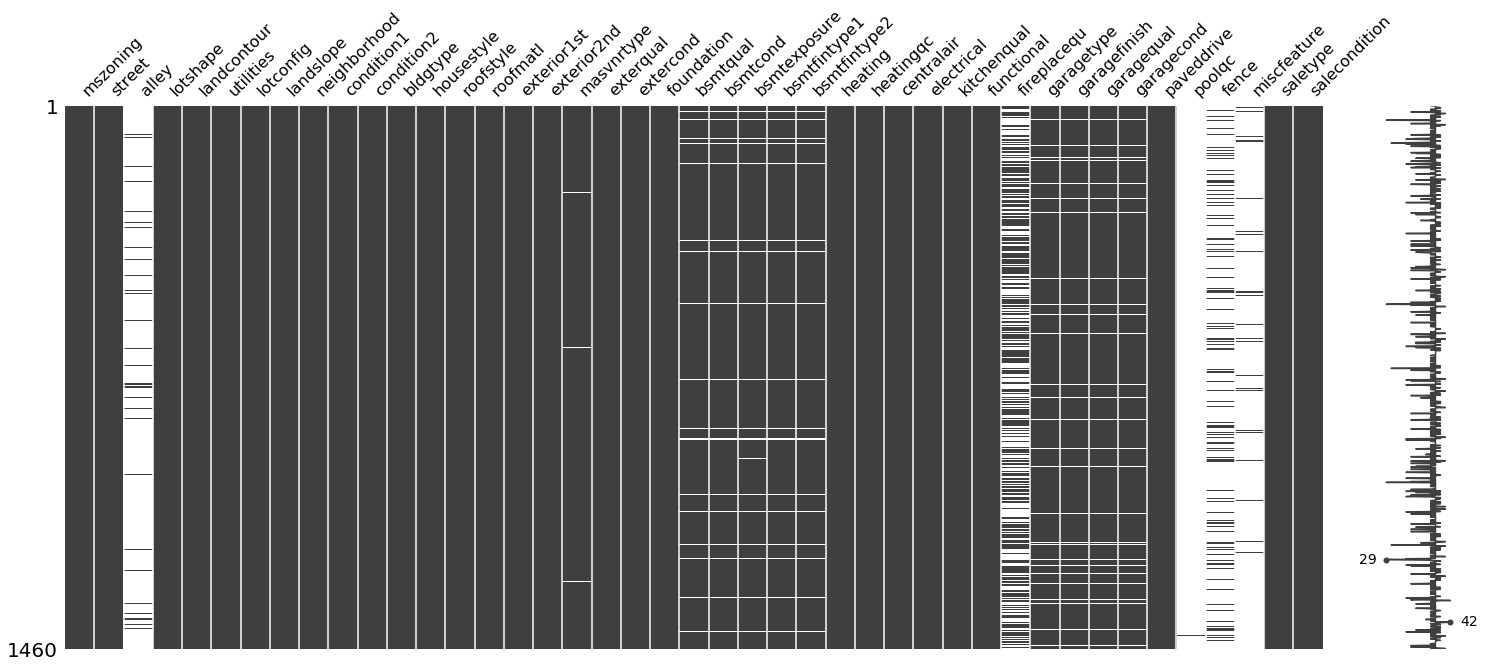

In [15]:
# Take a look at nulls again
# Strip out the categorical columns and visualize the nulls
categorical_df = houses_raw.select_dtypes(include=["category","object","datetime64[ns]"])

# Visualize the nulls
report_null_entries(categorical_df)

Number of null values: 339


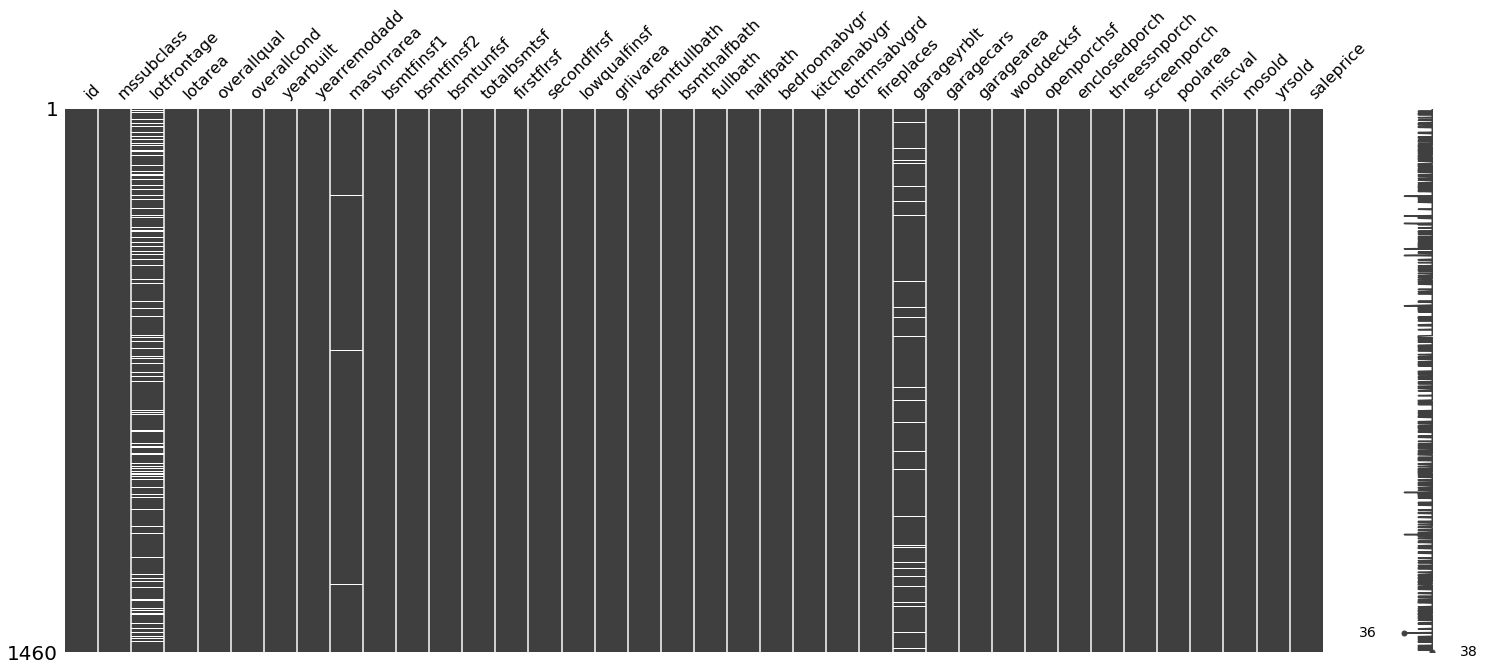

In [16]:
# Strip out the categorical columns and visualize the nulls
continuous_df = houses_raw.select_dtypes(exclude=["category","object"])

# Visualize the nulls
report_null_entries(continuous_df)

In [17]:
# Having interpolated as much as possible, drop columns with null values
houses_working = houses_raw.copy()
houses_working.dropna(axis="columns",inplace=True)
houses_working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 62 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotarea          1460 non-null int64
street           1460 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-null object
exterior2nd      1460 non-null object
exterqual        1460 non-

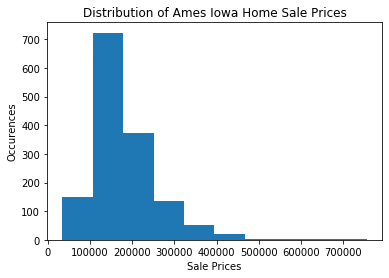

In [18]:
# Look at at the target value distribution 
plt.hist(houses_working["saleprice"])
plt.title("Distribution of Ames Iowa Home Sale Prices")
plt.xlabel("Sale Prices")
plt.ylabel("Occurences")
plt.show()

In [19]:
# Plot a correlation matrix of the continuous variables 
continuous_df = houses_working.select_dtypes(exclude=["category","object","datetime64[ns]"])
corr_matrix = continuous_df.corr()
corr_matrix

,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
id,1.000000,0.011156,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.005024,-0.005968,-0.007940,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
mssubclass,0.011156,1.000000,-0.139781,0.032628,-0.059316,0.027850,0.040581,-0.069836,-0.065649,-0.140759,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
lotarea,-0.033226,-0.139781,1.000000,0.105806,-0.005636,0.014228,0.013788,0.214103,0.111170,-0.002618,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
overallqual,-0.028365,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.239666,-0.059119,0.308159,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
overallcond,0.012609,-0.059316,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.046231,0.040229,-0.136841,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
yearbuilt,-0.012713,0.027850,0.014228,0.572323,-0.375983,1.000000,0.592855,0.249503,-0.049107,0.149040,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
yearremodadd,-0.021998,0.040581,0.013788,0.550684,0.073741,0.592855,1.000000,0.128451,-0.067759,0.181133,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
bsmtfinsf1,-0.005024,-0.069836,0.214103,0.239666,-0.046231,0.249503,0.128451,1.000000,-0.050117,-0.495251,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
bsmtfinsf2,-0.005968,-0.065649,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.050117,1.000000,-0.209294,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378
bsmtunfsf,-0.007940,-0.140759,-0.002618,0.308159,-0.136841,0.149040,0.181133,-0.495251,-0.209294,1.000000,...,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,-0.023837,0.034888,-0.041258,0.214479


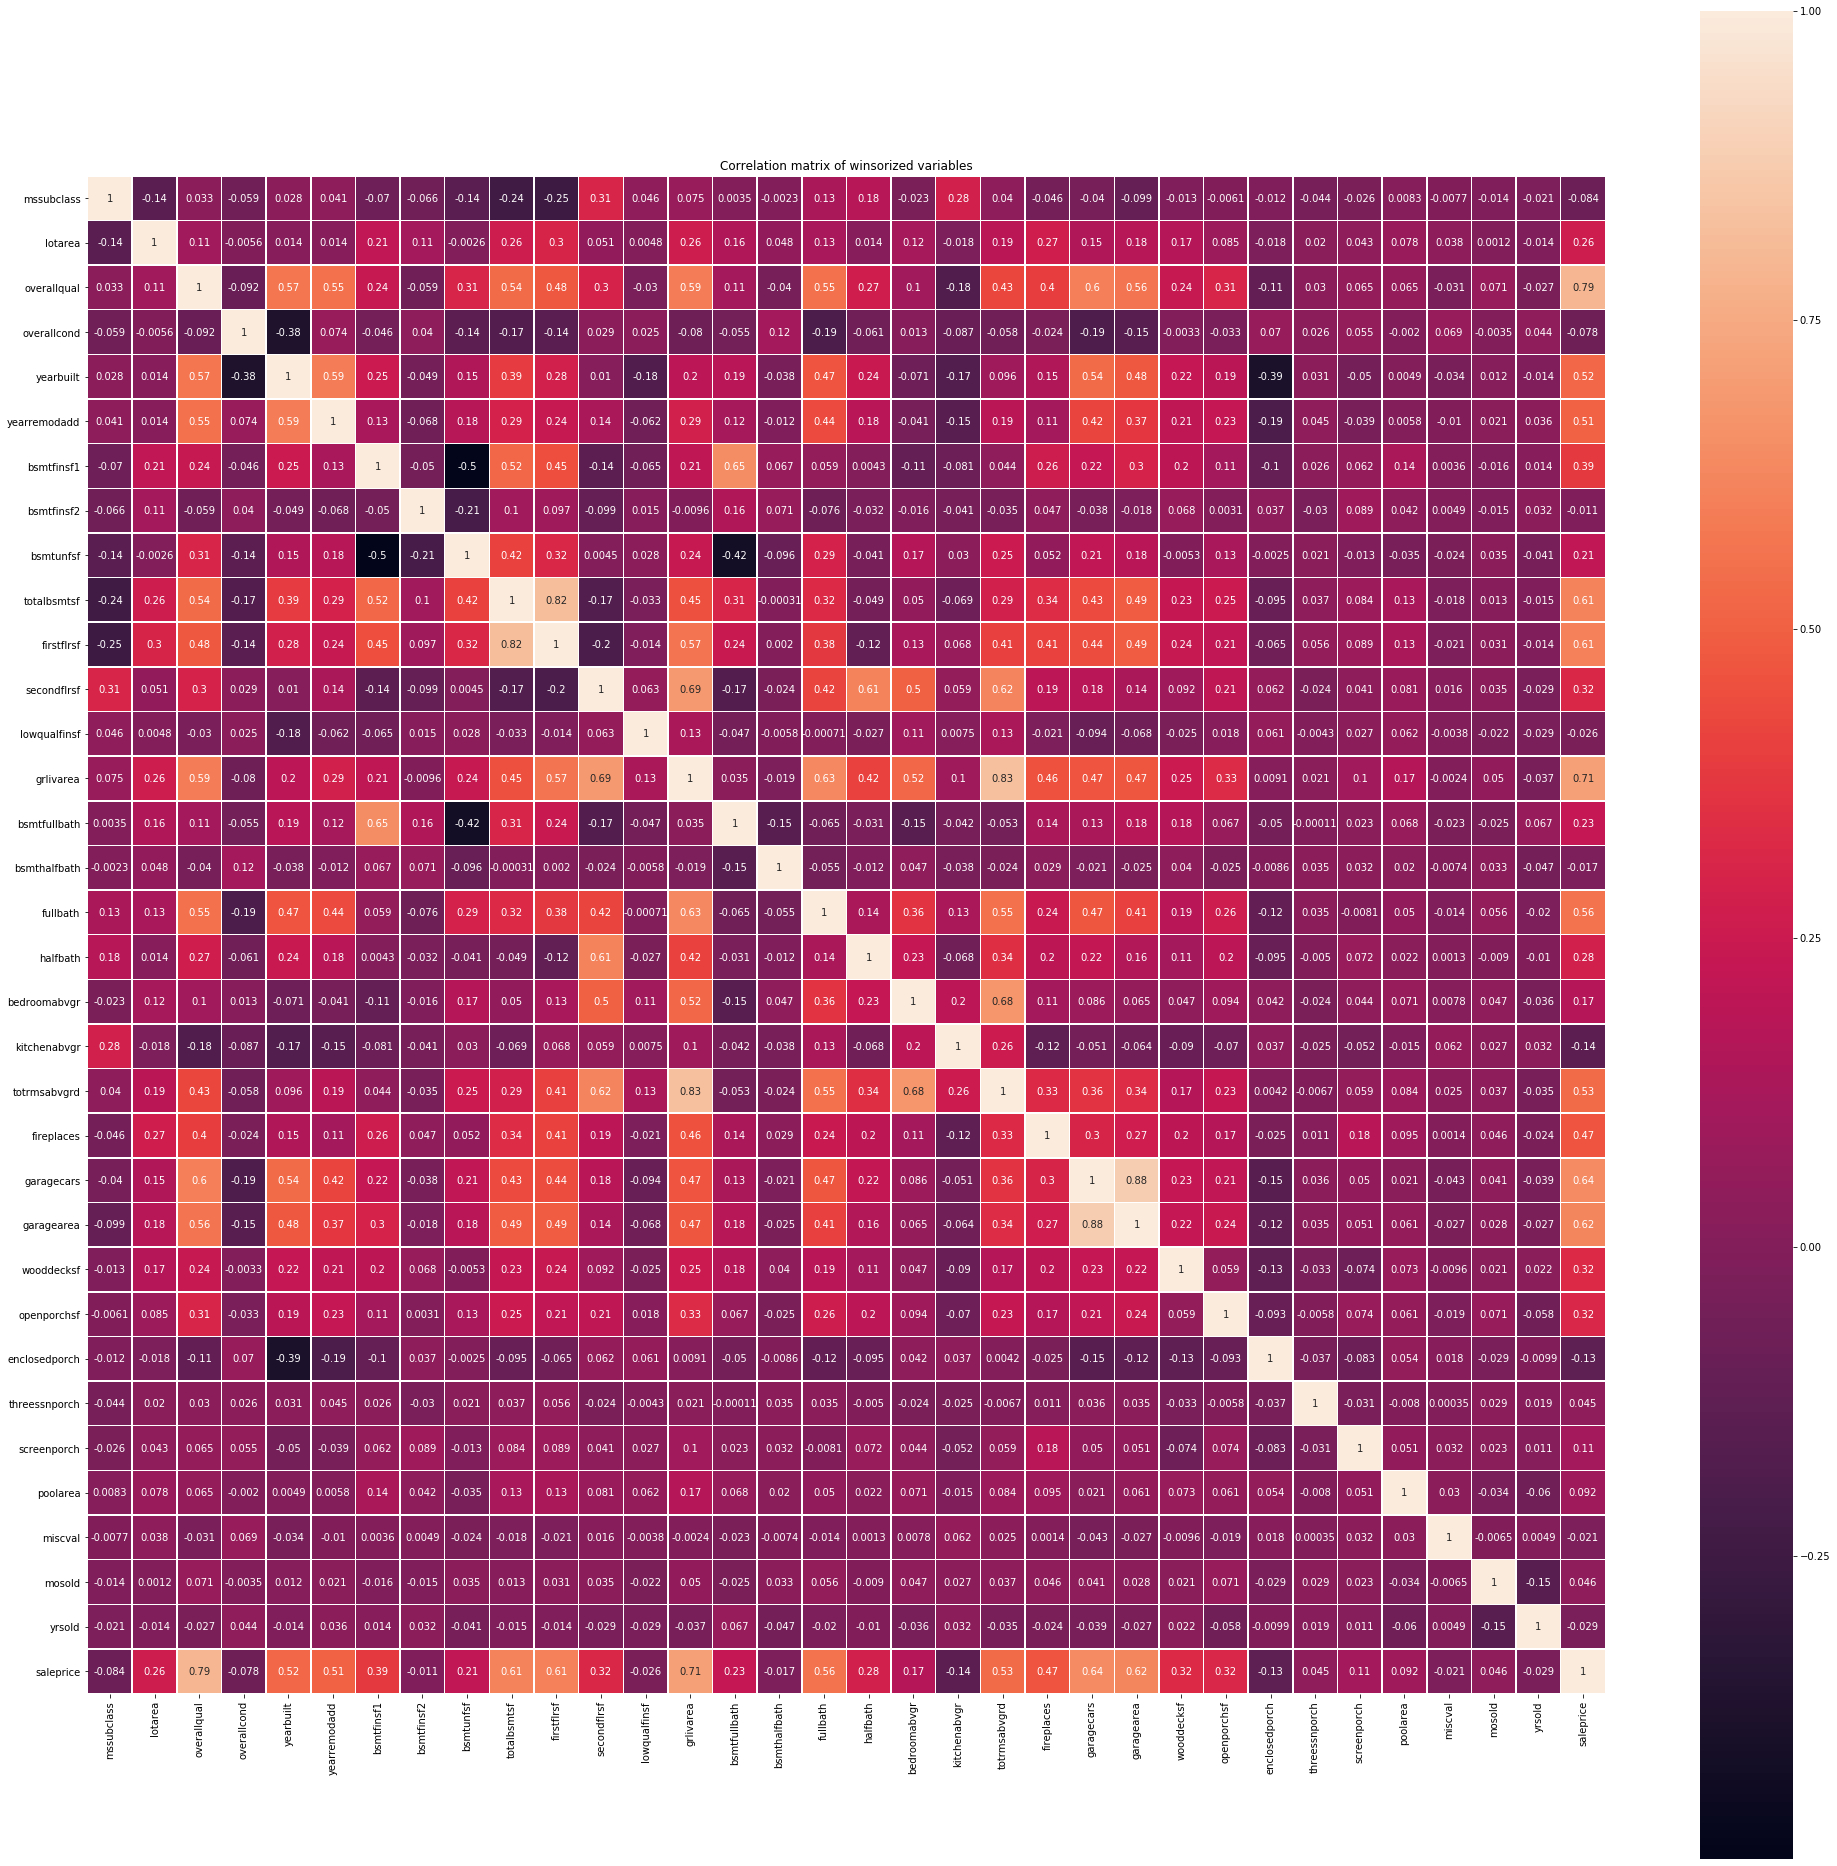

In [23]:
# Get a column count to set the figure size
col_count = len(corr_matrix.iloc[1:,1:].columns)

# Plot the correlation matrix
corr_plot(corr_matrix.iloc[1:,1:],(col_count,col_count))

In [28]:
# Pull the selected continuous columns into an new dataframe to be joined with engineered columns for the mdl 
reg_model = houses_working[["overallqual","totalbsmtsf","firstflrsf","grlivarea","garagecars","garagearea",
    "kitchenabvgr","enclosedporch","saleprice"]]

# Append dummies for the mszoning categorical variable to the reg_model dataframe
reg_model = pd.concat([reg_model, 
    pd.get_dummies(houses_raw.mszoning, prefix="mszoning",  drop_first=True)], axis=1)

# Append dummies for the street categorical variable to the reg_model dataframe
reg_model = pd.concat([reg_model, 
    pd.get_dummies(houses_raw.street, prefix="street", drop_first=True)], axis=1)

# Create a list of column names for the 
dummy_column_names = list(pd.get_dummies(houses_raw.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houses_raw.street, prefix="street", drop_first=True).columns)

reg_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
overallqual      1460 non-null int64
totalbsmtsf      1460 non-null int64
firstflrsf       1460 non-null int64
grlivarea        1460 non-null int64
garagecars       1460 non-null int64
garagearea       1460 non-null int64
kitchenabvgr     1460 non-null int64
enclosedporch    1460 non-null int64
saleprice        1460 non-null int64
mszoning_FV      1460 non-null uint8
mszoning_RH      1460 non-null uint8
mszoning_RL      1460 non-null uint8
mszoning_RM      1460 non-null uint8
street_Pave      1460 non-null uint8
dtypes: int64(9), uint8(5)
memory usage: 109.9 KB


In [44]:
# Y is the target variable
Y = reg_model["saleprice"]

# X is the feature set
X = reg_model[list(reg_model.iloc[:,:8].columns) + dummy_column_names]


In [45]:
# Add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     382.6
Date:                Thu, 26 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:38:47   Log-Likelihood:                -17456.
No. Observations:                1460   AIC:                         3.494e+04
Df Residuals:                    1446   BIC:                         3.501e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.758e+04   1.87e+04     -4.696      0.000   -1.24e+05    -5.1e+04
overallqual    2.187e+04   1120.914     19.509      0.000    1.97e+04    2.41e+04
totalbsmtsf      21.0612      4.245      4.962      0.000      12.735      29.388
firstflrsf       11.7843      5.064      2.327      0.020       1.851      21.718
grlivarea        47.5968      2.683     17.740      0.000      42.334      52.860
garagecars     1.416e+04   2973.056      4.764      0.000    8331.652       2e+04
garagearea       12.4068     10.334      1.201      0.230      -7.864      32.677
kitchenabvgr  -2.724e+04   4871.731     -5.592      0.000   -3.68e+04   -1.77e+04
enclosedporch   -39.0039     16.892     -2.309      0.021     -72.139      -5.868
mszoning_FV    2.241e+04   1.36e+04      1.649      0.099   -4245.672    4.91e+04
mszoning_RH    1.699e+04   1.57e+04      1.081      0.280   -1.38e+04    4.78e+04
mszoning_RL    2.413e+04   1.26e+04      1.909      0.057    -669.455    4.89e+04
mszoning_RM    7860.4908   1.28e+04      0.616      0.538   -1.72e+04    3.29e+04
street_Pave    4129.9653   1.61e+04      0.256      0.798   -2.75e+04    3.58e+04
==============================================================================
Omnibus:                      437.697   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47997.785
Skew:                          -0.239   Prob(JB):                         0.00
Kurtosis:                      31.085   Cond. No.                     6.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""